# Software Reliability Engineering - FISAC

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from tqdm import tqdm  


In [2]:
df = pd.read_csv('jm1.csv')
df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17.0,36.0,112.0,86.0,13.0,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17.0,135.0,329.0,271.0,5.0,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11.0,16.0,76.0,50.0,7.0,True


In [3]:
df.shape

(13204, 22)

### Software Reliability Models

#### Jelinsky-Moranda Model

In [4]:
def jelinski_moranda(failures, theta0, beta):
    return theta0 * np.exp(-beta * np.arange(len(failures)))

initial_params = [0.1, 0.1]
params, _ = curve_fit(jelinski_moranda, np.arange(len(df)), df['defects'], p0=initial_params)
print(f"JM Model Parameters: {params}")

JM Model Parameters: [1.42827859e+00 5.96523549e-04]


C:\Users\Rishabh\AppData\Local\Temp\ipykernel_3492\3113981288.py:2: RuntimeWarning: overflow encountered in exp
  return theta0 * np.exp(-beta * np.arange(len(failures)))


#### Non-Homogeneous Poisson Process

In [5]:
def nhpp_model(t, theta0, beta):
    return theta0 * np.exp(-beta * t)

# Fit the NHPP model
params, _ = curve_fit(nhpp_model, np.arange(len(df)), df['defects'], p0=initial_params)
print(f"NHPP Model Parameters: {params}")


NHPP Model Parameters: [1.42827859e+00 5.96523549e-04]


C:\Users\Rishabh\AppData\Local\Temp\ipykernel_3492\445557386.py:2: RuntimeWarning: overflow encountered in exp
  return theta0 * np.exp(-beta * t)


#### Littlewood-Verall Model

In [6]:
def littlewood_verall(t, a, b):
    return a * (1 - np.exp(-b * t))

# Fit the Littlewood-Verall model
params, _ = curve_fit(littlewood_verall, np.arange(len(df)), df['defects'], p0=initial_params)
print(f"Littlewood-Verall Model Parameters: {params}")


Littlewood-Verall Model Parameters: [ 0.15928198 25.32055795]


#### Weibull Model 

In [7]:
def weibull_model(t, a, b, c):
    return a * t ** (b - 1) * np.exp(-c * t)

# Fit the Weibull model
params, _ = curve_fit(weibull_model, np.arange(len(df)), df['defects'], p0=[1, 1, 1])
print(f"Weibull Model Parameters: {params}")


Weibull Model Parameters: [1. 1. 1.]


C:\Users\Rishabh\AppData\Local\Temp\ipykernel_3492\4136424108.py:2: RuntimeWarning: divide by zero encountered in power
  return a * t ** (b - 1) * np.exp(-c * t)
C:\Users\Rishabh\AppData\Local\Temp\ipykernel_3492\4136424108.py:2: RuntimeWarning: overflow encountered in exp
  return a * t ** (b - 1) * np.exp(-c * t)


### Prediction Models - Moving Averages

In [8]:
df['mean_2'] = df['defects'].rolling(window=2).mean()
df['mean_3'] = df['defects'].rolling(window=3).mean()
df['mean_4'] = df['defects'].rolling(window=4).mean()

# Tabulate u-values for evaluation
print(df[['defects', 'mean_2', 'mean_3', 'mean_4']].head())


   defects  mean_2    mean_3  mean_4
0    False     NaN       NaN     NaN
1     True     0.5       NaN     NaN
2     True     1.0  0.666667     NaN
3     True     1.0  1.000000    0.75
4     True     1.0  1.000000    1.00


### Kolmogorov-Smirnov Test

KS Statistic: 0.15919418358073312
P-value: 1.2692040789166808e-146


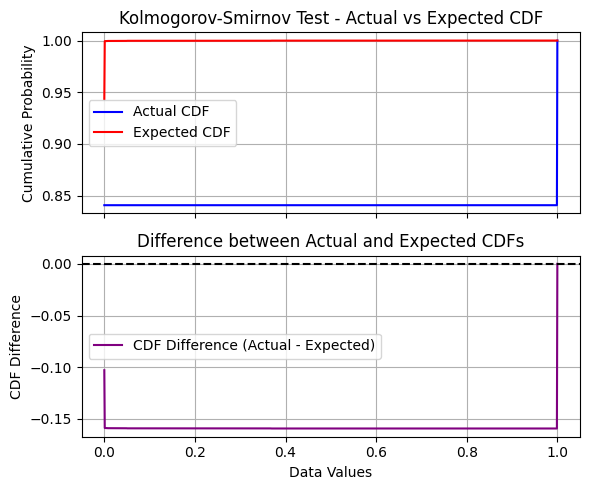

In [ ]:
from scipy.stats import ks_2samp
import numpy as np

if len(params) > 2:
    params = params[:2]

predictions = jelinski_moranda(np.arange(len(df)), *params)

ks_stat, p_value = ks_2samp(df['defects'], predictions)
print(f"KS Statistic: {ks_stat}\nP-value: {p_value}")

x_values = np.linspace(min(min(df['defects']), min(predictions)), max(max(df['defects']), max(predictions)), 1000)

actual_sorted = np.sort(df['defects'])
expected_sorted = np.sort(predictions)
actual_cdf = np.searchsorted(actual_sorted, x_values, side='right') / len(actual_sorted)
expected_cdf = np.searchsorted(expected_sorted, x_values, side='right') / len(expected_sorted)

cdf_difference = actual_cdf - expected_cdf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(x_values, actual_cdf, label="Actual CDF", color="blue", linestyle='-')
ax1.plot(x_values, expected_cdf, label="Expected CDF", color="red", linestyle='-')
ax1.set_ylabel("Cumulative Probability")
ax1.set_title("Kolmogorov-Smirnov Test - Actual vs Expected CDF")
ax1.legend()
ax1.grid(True)

ax2.plot(x_values, cdf_difference, label="CDF Difference (Actual - Expected)", color="purple", linestyle='-')
ax2.axhline(0, color='black', linestyle='--')
ax2.set_xlabel("Data Values")
ax2.set_ylabel("CDF Difference")
ax2.set_title("Difference between Actual and Expected CDFs")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Least Mean Squared Analysis

In [10]:
df['defects'] = df['defects'].astype(int)
model = ols('defects ~ loc + v + l + i', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                defects   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     304.8
Date:                Tue, 05 Nov 2024   Prob (F-statistic):          3.49e-251
Time:                        11:36:57   Log-Likelihood:                -4878.2
No. Observations:               13204   AIC:                             9766.
Df Residuals:                   13199   BIC:                             9804.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0978      0.006     16.464      0.0

### Prequential Analysis

In [11]:
df['defects'] = df['defects'].astype(int)
features = ['loc', 'v', 'l', 'i']
target = 'defects'
X = df[features].values
y = df[target].values

model = SGDClassifier(max_iter=10, tol=1e-3, random_state=0)

batch_size = 4 
mse_scores = []
accuracy_scores = []

for i in tqdm(range(batch_size, len(X), batch_size)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:i + batch_size], y[i:i + batch_size]
    
    model.partial_fit(X_train, y_train, classes=np.unique(y))
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    mse_scores.append(mse)
    accuracy_scores.append(acc)

avg_mse = np.mean(mse_scores)
avg_acc = np.mean(accuracy_scores)

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")

  0%|          | 0/3300 [00:00<?, ?it/s]

100%|██████████| 3300/3300 [00:05<00:00, 569.74it/s]

Average MSE: 0.2529
Average Accuracy: 0.7471


### Improving Accuracy 

#### Optimal Data Selection - Outlier Removal

In [24]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=0)
outliers = iso_forest.fit_predict(X)

X_filtered = X[outliers == 1]
y_filtered = y[outliers == 1]

print(f"Number of Outliers: {np.sum(outliers == -1)}")

print(pd.DataFrame(X_filtered).shape)
print(pd.DataFrame(X).shape)

Number of Outliers: 661
(12543, 4)
(13204, 4)


### Operational Profile

In [ ]:
import pandas as pd
import numpy as np

operations = [
    "Data Processing",
    "File Management",
    "Error Handling",
    "User Interface Update",
    "Data Validation",
    "System Communication",
    "Logging",
    "Memory Management",
    "Computation Intensive Task",
    "Network Operation"
]

num_operations = len(operations)
probabilities = np.random.dirichlet(np.ones(num_operations), size=1)[0]
total_test_cases = 1000
test_cases = (probabilities * total_test_cases).astype(int)

operational_profile = pd.DataFrame({
    "Operation": operations,
    "Probability": probabilities,
    "Assigned Test Cases": test_cases
})

operational_profile


,Operation,Probability,Assigned Test Cases
0,Data Processing,0.021738,21
1,File Management,0.099235,99
2,Error Handling,0.048814,48
3,User Interface Update,0.179455,179
4,Data Validation,0.100029,100
5,System Communication,0.043709,43
6,Logging,0.128454,128
7,Memory Management,0.096813,96
8,Computation Intensive Task,0.113960,113
9,Network Operation,0.167794,167


### Reliability Testing - Regression Testing


Regression testing is a type of software testing that verifies that updates or changes to a software product do not impact its existing functionality

In [13]:
initial_preds = model.predict(X_test)

for i in range(5):
    model.partial_fit(X_filtered, y_filtered, classes=np.unique(y_filtered))
    
    initial_preds = model.predict(X_test)
    mse = mean_squared_error(y_test, initial_preds)
    acc = accuracy_score(y_test, initial_preds)
    
    print(f"Iteration {i + 1} - MSE: {mse:.4f}, Accuracy: {acc:.4f}")

Iteration 1 - MSE: 0.0000, Accuracy: 1.0000
Iteration 2 - MSE: 0.0000, Accuracy: 1.0000
Iteration 3 - MSE: 0.0000, Accuracy: 1.0000
Iteration 4 - MSE: 0.0000, Accuracy: 1.0000
Iteration 5 - MSE: 0.0000, Accuracy: 1.0000


The retest is consistent with the test hence verified that functionality remains same

### Markov Model for Test Case Optimization

In [14]:
import numpy as np

transition_matrix = np.array([
    [0.7, 0.3],
    [0.4, 0.6]
])

def markov_chain_tests(steps, matrix, initial_state=0):
    state = initial_state
    for _ in range(steps):
        state = np.random.choice([0, 1], p=matrix[state])
    return state

optimized_tests = [markov_chain_tests(10, transition_matrix) for _ in range(10)]
print(f"Optimized Test States: {optimized_tests}")

Optimized Test States: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


### Certification Bodies

- **NASA Software Assurance** - For projects within NASA’s scope.
- **ISO 9001/IEC 61508** - International standards for system reliability and quality.
- **CMMI (Capability Maturity Model Integration)** - For assessing process improvement in software development.


### Risk Analysis

Dummy Statistics for Risk Analysis 

In [15]:
import pandas as pd

risks = pd.DataFrame({
    'Risk': ['Data Loss', 'Model Drift', 'Overfitting'],
    'Probability': [0.3, 0.5, 0.7],
    'Impact': [8, 6, 9]
})
risks['Risk Level'] = risks['Probability'] * risks['Impact']
risks

,Risk,Probability,Impact,Risk Level
0,Data Loss,0.3,8,2.4
1,Model Drift,0.5,6,3.0
2,Overfitting,0.7,9,6.3


### Metrics Calculation

#### Cyclometric Complexity

In [16]:
import os
os.system("radon cc -s -a model.py")

0

#### Cohesion and Coupling

In [17]:
code_block = """
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from tqdm import tqdm

df = pd.read_csv('jm1.csv')

df['defects'] = df['defects'].astype(int)
features = ['loc', 'v', 'l', 'i']
target = 'defects'
X = df[features].values
y = df[target].values

model = SGDClassifier(max_iter=10, tol=1e-3, random_state=0)

batch_size = 4 
mse_scores = []
accuracy_scores = []

for i in tqdm(range(batch_size, len(X), batch_size)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:i + batch_size], y[i:i + batch_size]
    
    model.partial_fit(X_train, y_train, classes=np.unique(y))
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    mse_scores.append(mse)
    accuracy_scores.append(acc)

avg_mse = np.mean(mse_scores)
avg_acc = np.mean(accuracy_scores)

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")
"""

import ast
from collections import defaultdict

def analyze_coupling(code_str):
    tree = ast.parse(code_str)
    imports = defaultdict(list)
    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            for name in node.names:
                imports["modules"].append(name.name)
        elif isinstance(node, ast.ImportFrom):
            imports["from_" + node.module].extend([name.name for name in node.names])
    return imports

coupling_info = analyze_coupling(code_block)
print("Modules and dependencies (indicative of coupling)\n\n", coupling_info)


Modules and dependencies (indicative of coupling)

 defaultdict(<class 'list'>, {'modules': ['pandas', 'numpy'], 'from_sklearn.linear_model': ['SGDClassifier'], 'from_sklearn.metrics': ['mean_squared_error', 'accuracy_score'], 'from_tqdm': ['tqdm']})


### GQM - Goal Question Metrics


#### Questions (Q) and Metrics (M)

1.  **How easy is the code to understand?**

    -   **M1.1: Cyclomatic Complexity**: Measures the number of independent paths through the code (lower complexity indicates easier comprehension).
    -   **M1.2: Comment Density**: Ratio of lines of comments to lines of code. High comment density can help in understanding.
    -   **M1.3: Function Length**: Measures the average length of functions (in lines). Shorter, more focused functions are typically easier to understand.
    -   **M1.4: Halstead Difficulty**: Measures complexity based on operators and operands in the code. Lower difficulty scores mean code is easier to interpret.
2.  **How easy is the code to modify?**

    -   **M2.1: Coupling Between Objects (CBO)**: Measures the degree of interdependence between modules. Lower coupling indicates the code is modular and easier to change.
    -   **M2.2: Lack of Cohesion of Methods (LCOM)**: Measures the degree to which methods within a class are related to each other. High cohesion (low LCOM score) implies that methods are logically grouped, making modification easier.
    -   **M2.3: Depth of Inheritance Tree (DIT)**: Indicates the levels of inheritance in the codebase. Lower inheritance depth typically results in fewer dependencies, making code easier to modify.
3.  **How easily can defects be located and fixed in the code?**

    -   **M3.1: Defect Density**: Measures the number of known defects per module. A low defect density is desirable for easy maintainability.
    -   **M3.2: Code Churn Rate**: Measures the number of changes over time in each module, indicating areas of the code that might be difficult to stabilize and maintain.
    -   **M3.3: Test Coverage**: Measures the percentage of code covered by automated tests. Higher test coverage typically implies that it's easier to find and fix issues.
4.  **How likely is the code to be stable over time?**

    -   **M4.1: Number of Code Smells**: Detects common patterns in the code that can make maintenance harder (e.g., long methods, large classes).
    -   **M4.2: Maintainability Index**: An overall score based on a combination of complexity, code lines, and other factors, indicating the maintainability of the module.